In [1]:
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/sa_update"
%pwd
import os
print(os.listdir())

Mounted at /content/drive
/content/drive/MyDrive/sa_update
['.ipynb_checkpoints', 'kqc_custom.py', '__pycache__', 'sa_update.ipynb', 'SA_ver2.py', 'SA_basefunctions.py']


In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
!pip install qiskit
!pip install qiskit_optimization
!pip install qiskit.utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.8 MB 5.1 MB/s 
     |████████████████████████████████| 19.2 MB 1.2 MB/s 
     |████████████████████████████████| 240 kB 47.9 MB/s 
     |████████████████████████████████| 106 kB 58.7 MB/s 
     |████████████████████████████████| 55 kB 3.4 MB/s 
     |████████████████████████████████| 37.5 MB 1.1 MB/s 
     |████████████████████████████████| 943 kB 57.3 MB/s 
     |████████████████████████████████| 49 kB 5.6 MB/s 
     |████████████████████████████████| 50 kB 6.4 MB/s 
     |████████████████████████████████| 4.1 MB 38.1 MB/s 
     |████████████████████████████████| 1.9 MB 54.5 MB/s 
     |████████████████████████████████| 112 kB 55.9 MB/s 
  Created wheel for qiskit: filename=qiskit-0.39.3-py3-none-any.whl size=12262 sha256=408f77b7b8cba78d72b4acf2a6f2bcea7e79ba5329dbe25e248f52dcb5df851e
  Stored in directory: /root/.cache/pip/wheels/b1/36/b2/6eb4e

In [209]:
from kqc_custom import generate_dependent_sample
from SA_ver2 import SimulatedAnnealing as SA

In [82]:
import matplotlib.pyplot as plt

In [88]:
from SA_basefunctions import get_QB as qb

# **데이터 생성**

In [195]:
X, y = generate_dependent_sample(500, 10, beta_coef=[4, 3, 2, 2], epsilon = 0.5, covariance_parameter = 10)
X = pd.DataFrame(X)
Q = np.cov(X.T)
Beta = np.ones(len(X.T))
ld = 0.7

In [196]:
binind_lst = []
qb_lst = []
for i in range(1,2**10):
    binind = [bool(int(j)) for j in bin(i)[2:]]
    binind = [False for i in range(10-len(binind))]+ binind
    binind_lst += [binind]
    X_choose = X.iloc[:, binind]
    qb_lst += [qb(X_choose, 10, Q, Beta, ld)]

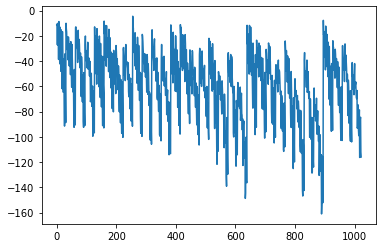

In [197]:
plt.plot(qb_lst)

In [198]:
qb(X, 10, Q, Beta, ld)  # 변수선택 없이 구한 objectitve function 값

-115.92364789286377

# **등호 제약식이 있는 SA**

In [216]:
'''
input 설명(순서대로)
X: data의 X
y: data의 y
schedule list: SA의 update 스케쥴을 의미, 
               단계와 단계별 업데이트 횟수로 [10, 20]이면 총 2단계 update로 1단계엔 10회, 2단계엔 20회 update를 진행함을 의미
               성능이 너무 낮다면 단계 수와 단계별 update 수를 늘려주면 됨(ex: [30, 40, 50])
               반대로 성능이 너무 높다면 줄여주면 됨(ex: [10])
k_flip: 몇 개씩 뒤집어서 search할지를 정해주면 됨. 단 equal condition에서는 "반드시 2의 배수"여야 함(1대 1로 update 되어야 개수가 유지되기 때문)
alpha, tau: 온도 낮추는 비율과 초기 온도인데... 그냥 alpha는 0.8~0.99 사이 값, tau는 1로 놓고 쓰면 됨
Q: Q matrix
Beta: Beta vector
Lambda: lambda
constraint: 몇 개로 등호 제약을 둘 것인지, 즉 총 몇 개가 선택되길 원하는지
condition: 반드시 뽑아야 하는 변수의 정수 index list, defalut 존재(빈 리스트)
'''

simulatedannealing = SA(X, y, [30, 50, 100], 2, 0.9, 1, Q = Q, Beta = Beta, Lambda = ld, constraint = 4, condition = [0])
sa_result = simulatedannealing.equal()

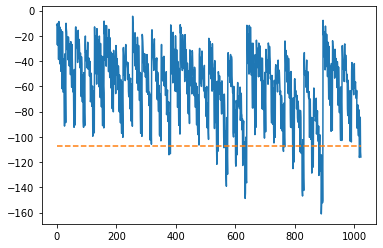

In [217]:
plt.plot(qb_lst)
plt.plot([i for i in range(1024)], [qb(sa_result, 10, Q, Beta, ld) for i in range(1024)], linestyle = 'dashed')

In [218]:
sa_result # 4개 등호 제약으로 4개의 변수 뽑힘, 변수 0 반드시 뽑힘

,0,5,6,8
0,-7.829785,-2.085298,2.740441,-2.448392
1,10.976963,6.095843,0.431581,2.833347
2,0.672092,3.345613,0.313443,6.092855
3,-7.165594,-6.425925,-1.133545,-3.414541
4,1.886018,-0.304151,-1.097234,5.418232
...,...,...,...,...
495,1.661781,2.663295,-0.882099,7.578279
496,-0.170246,5.589628,3.400144,6.201142
497,-13.257476,-6.114456,0.666729,-3.938359
498,-2.902046,0.741478,2.228890,-0.543059


# **이하 제약식이 있는 SA**

In [219]:
'''
input 설명(순서대로)
X: data의 X
y: data의 y
schedule list: SA의 update 스케쥴을 의미, 
               단계와 단계별 업데이트 횟수로 [10, 20]이면 총 2단계 update로 1단계엔 10회, 2단계엔 20회 update를 진행함을 의미
               성능이 너무 낮다면 단계 수와 단계별 update 수를 늘려주면 됨(ex: [30, 40, 50])
               반대로 성능이 너무 높다면 줄여주면 됨(ex: [10])
k_flip: 몇 개씩 뒤집어서 search할지를 정해주면 됨. unequal condition에서는 2의 배수일 필요 없음
alpha, tau: 온도 낮추는 비율과 초기 온도인데... 그냥 alpha는 0.8~0.99 사이 값, tau는 1로 놓고 쓰면 됨
Q: Q matrix
Beta: Beta vector
Lambda: lambda
constraint: 몇 개로 부등호 제약을 둘 것인지, 즉 총 몇 개 이하로 뽑을 것인지
condition: 반드시 뽑아야 하는 변수의 정수 index list, defalut 존재(빈 리스트)
'''

simulatedannealing = SA(X, y, [30, 50, 100], 1, 0.9, 1, Q = Q, Beta = Beta, Lambda = ld, constraint = 9, condition = [0, 1])
sa_result2 = simulatedannealing.unequal()

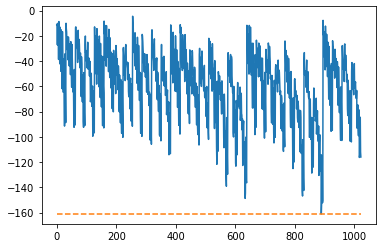

In [220]:
plt.plot(qb_lst)
plt.plot([i for i in range(1024)], [qb(sa_result2, 10, Q, Beta, ld) for i in range(1024)], linestyle = 'dashed')

In [221]:
sa_result2  # 9개 이하의 제약으로 총 7개의 변수 뽑힘, 변수 0과 1 반드시 뽑힘

,0,1,3,4,5,6,8
0,-7.829785,3.185001,-3.195305,2.240202,-2.085298,2.740441,-2.448392
1,10.976963,-2.391829,-1.242987,-1.510718,6.095843,0.431581,2.833347
2,0.672092,-4.793522,-4.741333,-5.123452,3.345613,0.313443,6.092855
3,-7.165594,-1.704284,-5.302297,-4.658252,-6.425925,-1.133545,-3.414541
4,1.886018,-5.702456,-3.359002,-3.806169,-0.304151,-1.097234,5.418232
...,...,...,...,...,...,...,...
495,1.661781,-4.282538,-0.387623,-2.839261,2.663295,-0.882099,7.578279
496,-0.170246,1.313604,-0.932862,0.608757,5.589628,3.400144,6.201142
497,-13.257476,-1.891520,-3.122351,-2.621966,-6.114456,0.666729,-3.938359
498,-2.902046,-0.386939,-5.867328,-3.553492,0.741478,2.228890,-0.543059


# **제약을 안 주고 싶은 경우**

In [225]:
'''
input 설명(순서대로)
X: data의 X
y: data의 y
schedule list: SA의 update 스케쥴을 의미, 
               단계와 단계별 업데이트 횟수로 [10, 20]이면 총 2단계 update로 1단계엔 10회, 2단계엔 20회 update를 진행함을 의미
               성능이 너무 낮다면 단계 수와 단계별 update 수를 늘려주면 됨(ex: [30, 40, 50])
               반대로 성능이 너무 높다면 줄여주면 됨(ex: [10])
k_flip: 몇 개씩 뒤집어서 search할지를 정해주면 됨. unequal condition에서는 2의 배수일 필요 없음
alpha, tau: 온도 낮추는 비율과 초기 온도인데... 그냥 alpha는 0.8~0.99 사이 값, tau는 1로 놓고 쓰면 됨
Q: Q matrix
Beta: Beta vector
Lambda: lambda
constraint: 제약을 안 줄거니까 전체 변수 개수(p)만큼 넣어주면 됨
condition: 반드시 뽑아야 하는 변수의 정수 index list, defalut 존재(빈 리스트)
'''

simulatedannealing = SA(X, y, [30, 50, 100], 1, 0.9, 1, Q = Q, Beta = Beta, Lambda = ld, constraint = 10)
sa_result3 = simulatedannealing.unequal()

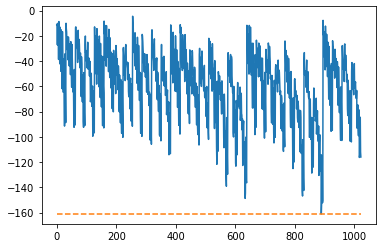

In [226]:
plt.plot(qb_lst)
plt.plot([i for i in range(1024)], [qb(sa_result3, 10, Q, Beta, ld) for i in range(1024)], linestyle = 'dashed')

In [227]:
sa_result3  # constraint 없음, 꼭 뽑아야 하는 변수도 없음.

,0,1,3,4,5,6,8
0,-7.829785,3.185001,-3.195305,2.240202,-2.085298,2.740441,-2.448392
1,10.976963,-2.391829,-1.242987,-1.510718,6.095843,0.431581,2.833347
2,0.672092,-4.793522,-4.741333,-5.123452,3.345613,0.313443,6.092855
3,-7.165594,-1.704284,-5.302297,-4.658252,-6.425925,-1.133545,-3.414541
4,1.886018,-5.702456,-3.359002,-3.806169,-0.304151,-1.097234,5.418232
...,...,...,...,...,...,...,...
495,1.661781,-4.282538,-0.387623,-2.839261,2.663295,-0.882099,7.578279
496,-0.170246,1.313604,-0.932862,0.608757,5.589628,3.400144,6.201142
497,-13.257476,-1.891520,-3.122351,-2.621966,-6.114456,0.666729,-3.938359
498,-2.902046,-0.386939,-5.867328,-3.553492,0.741478,2.228890,-0.543059
